Gaussian process has been pointed out as a shallow but infinitely wide neural network (NN) with Gaussian weights.
- [Neal 1996](https://link.springer.com/chapter/10.1007/978-1-4612-0745-0_2)
- [Matthews et al. 2018](https://arxiv.org/abs/1804.11271)
- [Lee et al. 2018](https://arxiv.org/abs/1711.00165)

The dynamic of training overparametrized NN process can be captured by the frame work of neural tangent kernel (NTK).
- [Jacot et al.](https://arxiv.org/abs/1806.07572)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# generate gaussian samples
def generate_gp_samples(num_points=10, noise_std=0.01):
    x = np.linspace(-2, 2, num_points)
    K = np.exp(-1. * (np.subtract.outer(x, x) ** 2))
    y = np.random.multivariate_normal(np.zeros(num_points), K) + noise_std * np.random.randn(num_points)
    return x, y

In [ ]:
config = {
    'learning_rate': 0.01,
    'num_epochs': 5000,
}


### A model with 1 hidden layer

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, hidden_dim, input_dim=1, output_dim=1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Prepare dataset

In [ ]:
x_train, y_train = generate_gp_samples()
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

x_test = np.linspace(-2, 2, 100)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

K_train = np.exp(-1. * (np.subtract.outer(x_train, x_train) ** 2))
K_test = np.exp(-1. * (np.subtract.outer(x_test, x_train) ** 2))
K_inv = np.linalg.inv(K_train + 1e-6 * np.eye(len(K_train)))  # 加入小的噪声以确保数值稳定性
y_test_true = K_test @ K_inv @ y_train

### Main

The current model's hidden layer size is 5
The current model's hidden layer size is 25
The current model's hidden layer size is 50000


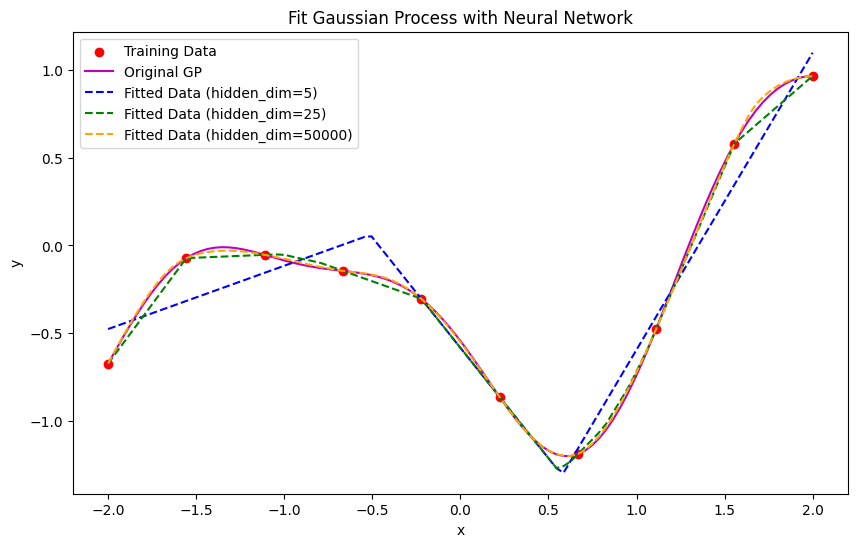

In [ ]:
hidden_dims = [5, 25, 50000]
colors = ['blue', 'green', 'orange']

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color='red', label='Training Data')
plt.plot(x_test, y_test_true, color='m', linestyle='-', label='Original GP')

for hidden_dim, color in zip(hidden_dims, colors):
    print("The current model's hidden layer size is {}".format(int(hidden_dim)))
    # initial model, optimizer, criterion
    model = SimpleNN(hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()

    # training loop
    for epoch in range(config['num_epochs']):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # inference
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test_tensor).squeeze().detach().cpu().numpy()

    # show the predict GP function
    plt.plot(x_test, y_pred, color=color, linestyle='--', label=f'Fitted Data (hidden_dim={hidden_dim})')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit Gaussian Process with Neural Network')
plt.show()